In [1]:
config='NATL60'
case='CJM165'
freq='1d'
region='GS'

year='2013'


In [2]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()
c

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:40818 Dashboard: http://127.0.0.1:39564/status,Cluster Workers: 8 Cores: 48 Memory: 134.91 GB


In [4]:
## path for mdules

import sys
sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/xscale")
import xscale

sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/diags-CMEMS-on-occigen/common-lib/")
import GriddedData

## imports

import numpy as np
import numpy.ma as ma
import xarray as xr
import time

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm
seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

import glob
import os 

%matplotlib inline

In [5]:
if region == 'EU':
    imin=3858
    imax=5076
    jmin=424
    jmax=3286
    
#cdffindij -w -80.418  -40.000   26.991   47.986 -c /store/molines/NATL60/NATL60-I/NATL60_coordinates_v4.nc
if region == 'GS':
    imin=63
    imax=2507
    jmin=29
    jmax=1611

In [6]:
## Dataset

gridfile='/store/molines/NATL60/NATL60-I/NATL60_coordinates_v4.nc'
maskfile='/store/molines/NATL60/NATL60-I/NATL60_v4.1_cdf_byte_mask.nc'
meshhgrfile='/store/molines/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_hgr.nc'
meshzgrfile='/store/molines/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_zgr.nc'

In [7]:
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat'][jmin:jmax,imin:imax]
navlon= grid['nav_lon'][jmin:jmax,imin:imax]


In [27]:
def filt(w):
    win_box2D = w.window
    win_box2D.set(window='hanning', cutoff=90, dim=['x', 'y'], n=[90, 90])
    bw = win_box2D.boundary_weights(drop_dims=[])
    w_LS = win_box2D.convolve(weights=bw)
    w_SS=w-w_LS
    return w_SS


In [9]:
def plot_fine_scale_variance(var,loncrs,latcrs,lon,lat,hpvarm,month,m,config,case):
    ''' map of the averaged fine scale variance
    '''
    if region == 'EU':
        fig, ax = plt.subplots(1,1,figsize=(10,15))
    if region == 'GS':
        fig, ax = plt.subplots(1,1,figsize=(15,10))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.autoscale(tight=True)
    cont=np.isnan(hpvarm)
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 25, 'color': 'gray'}
    gl.ylabel_style = {'size': 25, 'color': 'gray'}
    
    ax.tick_params('both',labelsize=25)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),cmap=seq_cmap,vmin=0,vmax=0.1,alpha=1)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True,colors='black')
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('Small scales surface vorticity variance in '+month+' for '+config+'-'+case,fontsize=15)
    plt.savefig('Plots/'+config+region+'-'+case+'_y'+year+'m'+m+'_fine_scale_variance_vorticity.png')
  

In [10]:
    month='03'
    date_list=[]
    if month == '03':
        dayf=31
    if month == '09':
        dayf=30
    for day in np.arange(1,dayf+1):
        if day < 10:
            date='y'+str(year)+'m'+str(month)+'d0'+str(day)
        else:
            date='y'+str(year)+'m'+str(month)+'d'+str(day)
        date_list.append(date)
    datadir='/store/molines/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'
    for date in date_list:
        fileU=datadir+'*/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_gridU.nc'
        fileV=datadir+'*/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_gridV.nc'
        filecurl='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_socurloverf.nc'
        if not os.path.exists(filecurl):
            print('Computing '+str(filecurl))
            !ln -sf $meshhgrfile mesh_hgr.nc
            !ln -sf $meshzgrfile mesh_zgr.nc
            !ulimit -s unlimited; cdfcurl -u $fileU vozocrtx -v $fileV vomecrty -l 1 -surf -overf -o $filecurl
            !rm mesh*
    filescurl='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_y'+str(year)+'m'+str(month)+'d??.'+str(freq)+'_socurloverf.nc'
    dscurl=xr.open_mfdataset(filescurl,chunks={'time_counter':1,'y':700,'x':1000})
    curl=dscurl.socurloverf


In [11]:
curl.shape

(31, 3454, 5422)

In [28]:
    curl_SS=filt(curl)
    curl_LS=curl-curl_SS


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [29]:
    hpcurl=curl_SS[:,jmin:jmax,imin:imax]


In [14]:
hpcurl.shape

(31, 1582, 2444)

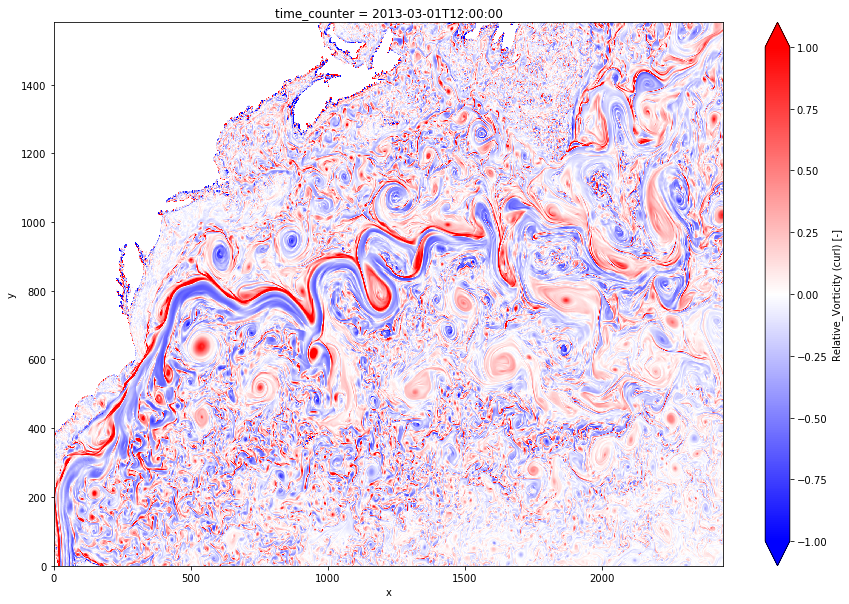

In [30]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
curl[0,jmin:jmax,imin:imax].plot(vmin=-1,vmax=1,cmap='bwr')

(31, 3454, 5422)


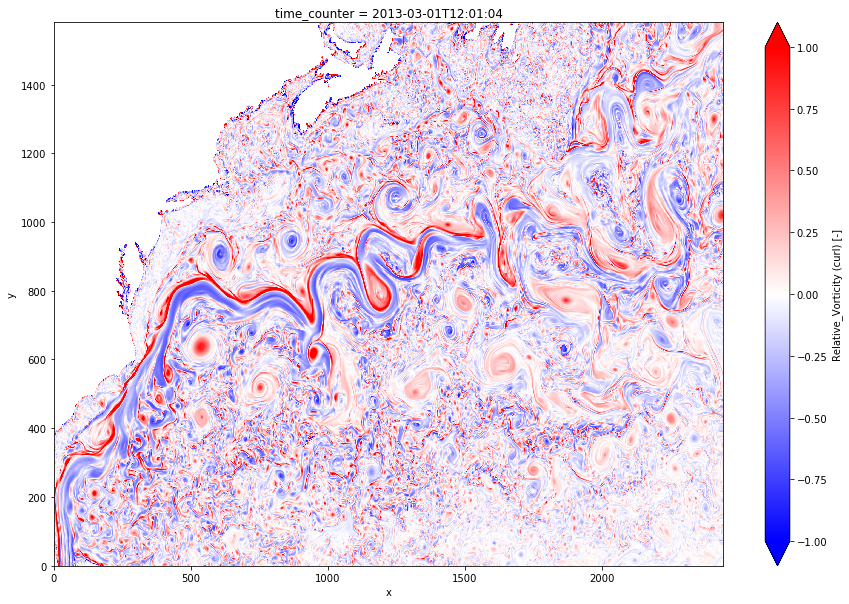

In [25]:
files='/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/curl/NATL60-CJM165_y2013m03d??.1d_socurloverf.nc'
ds2=xr.open_mfdataset(files,chunks={'time_counter':1,'y':700,'x':1000})
curl2=ds2.socurloverf
print(curl2.shape)
fig, ax = plt.subplots(1,1,figsize=(15,10))
curl2[0,jmin:jmax,imin:imax].plot(vmin=-1,vmax=1,cmap='bwr')

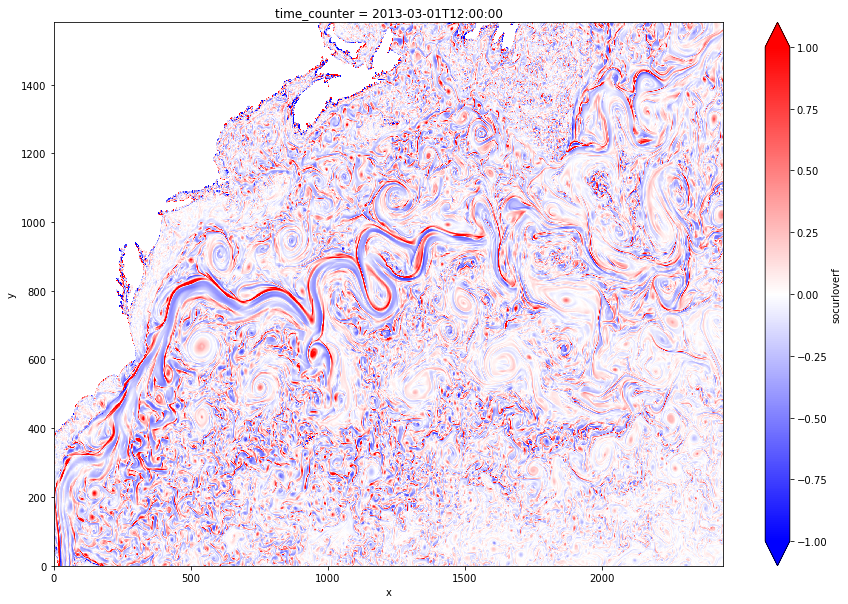

In [31]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
hpcurl[0].plot(vmin=-1,vmax=1,cmap='bwr')

(31, 3454, 5422)


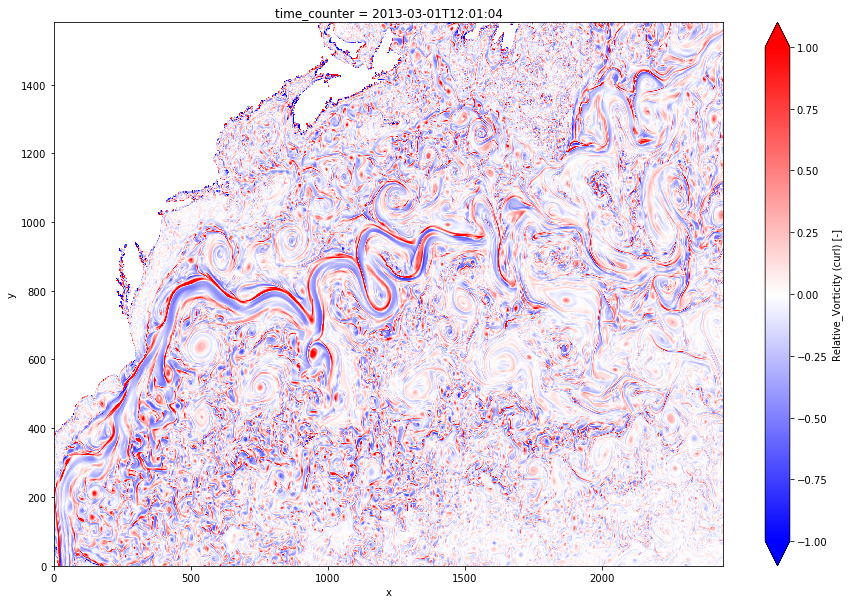

In [23]:
files='/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/curl/NATL60-CJM165_y2013m03d??.1d_socurloverf_filt-n80-f0.0125.nc'
ds2=xr.open_mfdataset(files,chunks={'time_counter':1,'y':700,'x':1000})
curl2=ds2.socurloverf_filt
print(curl2.shape)
fig, ax = plt.subplots(1,1,figsize=(15,10))
curl2[0,jmin:jmax,imin:imax].plot(vmin=-1,vmax=1,cmap='bwr')

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


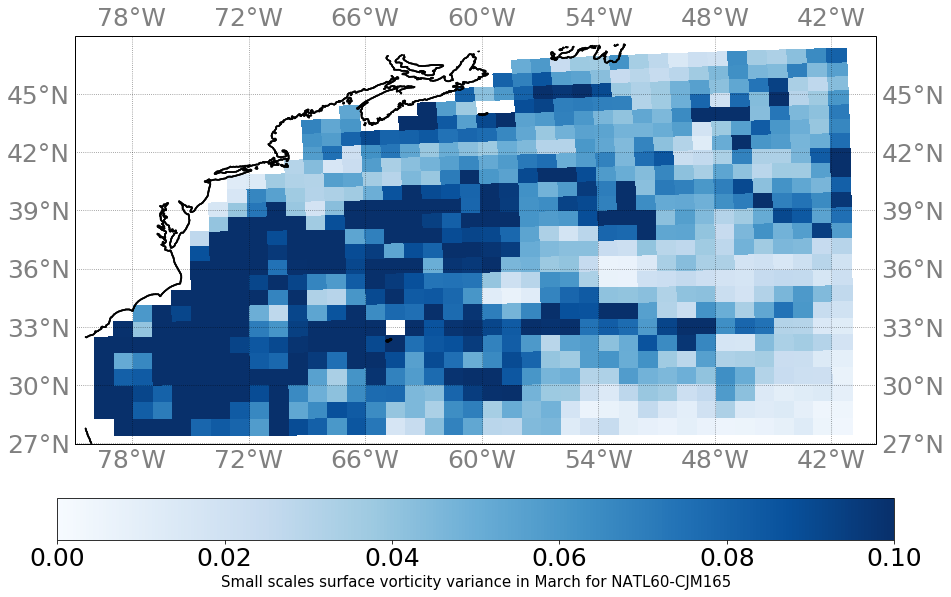

distributed.nanny - WARNING - Worker process 61907 was killed by signal 9
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 61911 was killed by signal 9
distributed.nanny - WARNING - Worker process 61909 was killed by signal 9
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 61915 was killed by signal 9
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 61913 was killed by signal 9
distributed.nanny - WARNING - Worker process 61919 was killed by signal 9
distributed.nanny - WARNING - Worker process 61917 was killed by signal 9
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 61921 was killed by signal 9
distributed.nanny - WARNING - Restarting worker


In [32]:
    hpcurl2 = hpcurl ** 2
    hpcurl2m = hpcurl2.mean(axis=0,keep_attrs=True)
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hpcurl2mc = crs.return_ravel(np.asarray(hpcurl2m))
    hpcurl2mcm = np.mean(hpcurl2mc,axis=-3)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)
    if month == '03':
        plot_fine_scale_variance(hpcurl2mcm,loncrsm, latcrsm,navlon,navlat,hpcurl2m,'March',month,config,case)
    if month == '09':
        plot_fine_scale_variance(hpcurl2mcm,loncrsm, latcrsm,navlon,navlat,hpcurl2m,'September',month,config,case)


In [31]:
def plot_vorticity_variance(month):
    date_list=[]
    if month == '03':
        dayf=31
    if month == '09':
        dayf=30
    for day in np.arange(1,dayf+1):
        if day < 10:
            date='y'+str(year)+'m'+str(month)+'d0'+str(day)
        else:
            date='y'+str(year)+'m'+str(month)+'d'+str(day)
        date_list.append(date)
    datadir='/store/molines/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'
    for date in date_list:
        fileU=datadir+'*/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_gridU.nc'
        fileV=datadir+'*/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_gridV.nc'
        filecurl='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_socurloverf.nc'
        if not os.path.exists(filecurl):
            print('Computing '+str(filecurl))
            !ln -sf $meshhgrfile mesh_hgr.nc
            !ln -sf $meshzgrfile mesh_zgr.nc
            !ulimit -s unlimited; cdfcurl -u $fileU vozocrtx -v $fileV vomecrty -l 1 -surf -overf -o $filecurl
            !rm mesh*
    filescurl='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_y'+str(year)+'m'+str(month)+'d??.'+str(freq)+'_socurloverf.nc'
    dscurl=xr.open_mfdataset(filescurl,chunks={'time_counter':1,'y':700,'x':1000})
    curl=dscurl.socurloverf[:,jmin:jmax,imin:imax]
    curl_SS=filt(curl)
    curl_LS=curl-curl_SS
    hpcurl=curl_SS
    hpcurl2 = hpcurl ** 2
    hpcurl2m = hpcurl2.mean(axis=0,keep_attrs=True)
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hpcurl2mc = crs.return_ravel(np.asarray(hpcurl2m))
    hpcurl2mcm = np.mean(hpcurl2mc,axis=-3)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)
    if month == '03':
        plot_fine_scale_variance(hpcurl2mcm,loncrsm, latcrsm,navlon,navlat,hpcurl2m,'March',month,config,case)
    if month == '09':
        plot_fine_scale_variance(hpcurl2mcm,loncrsm, latcrsm,navlon,navlat,hpcurl2m,'September',month,config,case)
        

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(s

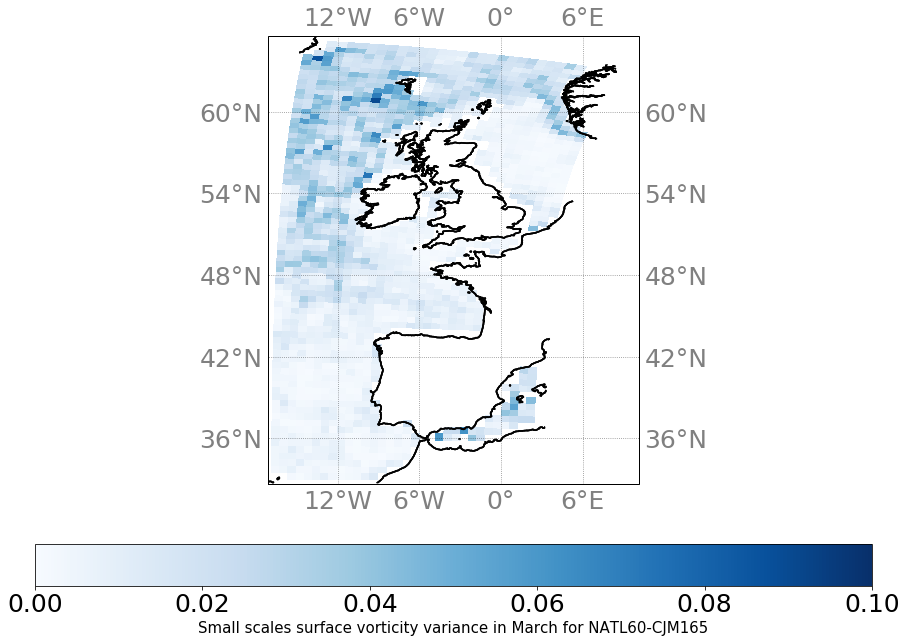

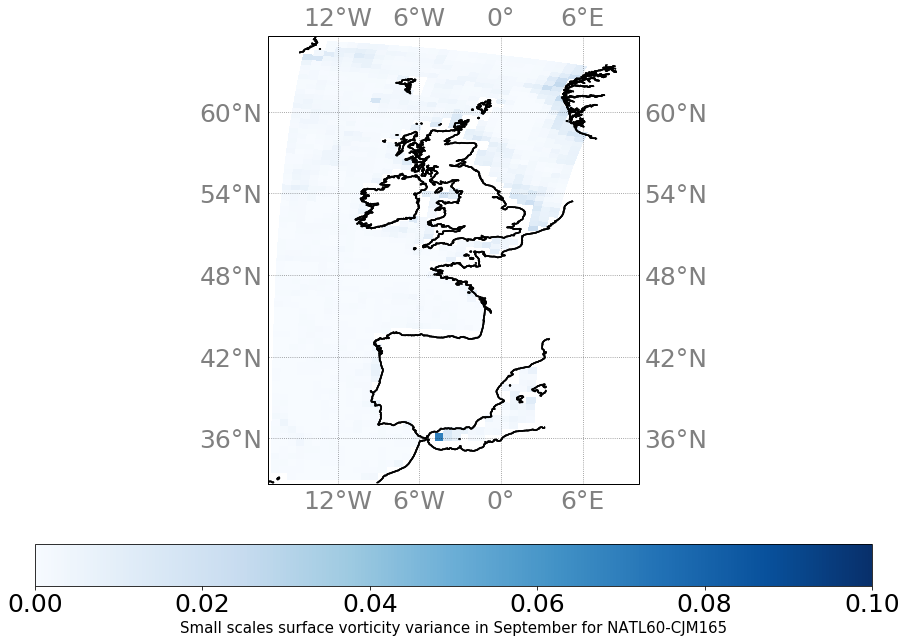

In [32]:
month_list=['03','09']

for month in month_list:
    if not os.path.exists('Plots/'+config+region+'-'+case+'_y'+year+'m'+month+'_fine_scale_variance_vorticity.png'):
        plot_vorticity_variance(month)